# Import Libraries

In [1]:
import pandas as pd
import configparser
import sqlalchemy
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data From SQL

In [2]:
config = configparser.ConfigParser()
config.read(r'../config.ini')
serverNames = config.get('Database', 'ServerName').split(',')
databaseNames = config.get('Database', 'DatabaseName').split(',')

connected = False

for i in range(max(len(serverNames), len(databaseNames))):
    try:
        print(f'Connection attempt to server "{serverNames[i].strip()}" database "{databaseNames[i].strip()}"...')
        engine = create_engine(f'mssql+pyodbc://{serverNames[i].strip()}/{databaseNames[i].strip()}?driver=SQL Server')
        connection = engine.connect()
        print('SQL server successfully connected')
        connected = True
        break
    except sqlalchemy.exc.OperationalError:
        print(f'SQL server failed to connect')

if not connected:
    raise RuntimeError("Could not connect to any SQL server")

print('Executing queries...')

cursor = connection.execute('SELECT * FROM [order]')
order = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

cursor = connection.execute('SELECT * FROM customer')
customer = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

cursor = connection.execute('SELECT * FROM label')
label = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

print('Queries executed')

connection.close()

Connection attempt to server "T2131-06\SQLEXPRESS" database "PAICA1"...
SQL server failed to connect
Connection attempt to server "NOTEBOOK\SQLEXPRESS" database "PAICA1"...
SQL server successfully connected
Executing queries...
Queries executed


In [3]:
customer.head()

,country_code,customer_id,mobile_verified,num_orders_last_50days,num_cancelled_orders_last_50days,num_refund_orders_last_50days,total_payment_last_50days,num_associated_customers,first_order_datetime
0,BD,a0afp7hz,True,19,0,0,135.932842,3,2015-12-01 14:06:14
1,BD,a0akr6uc,True,31,1,0,312.243169,2,2017-09-13 08:26:51
2,BD,a0aya4cb,True,34,0,0,381.789276,3,2016-02-29 13:45:03
3,BD,a0bwh4cs,True,51,0,0,611.814571,1,2015-12-16 16:08:34
4,BD,a0cor0bv,True,36,0,0,504.551619,3,2016-05-29 10:10:00


In [4]:
order.head()

,country_code,order_id,collect_type,payment_method,order_value,num_items_ordered,refund_value,order_date
0,BD,a019-193t,delivery,payment on delivery,2.715622,1,2.69,2023-02-03
1,BD,a019-1gmw,delivery,payment on delivery,7.881392,3,0.00,2023-02-10
2,BD,a019-208i,delivery,payment on delivery,5.158060,35,0.00,2023-02-28
3,BD,a019-23q5,delivery,credit card,6.299720,2,0.00,2023-05-02
4,BD,a019-2ui3,delivery,payment on delivery,3.433311,2,0.00,2023-02-11


In [5]:
label.head()

,country_code,order_id,customer_id,is_fraud
0,BD,a019-193t,bdkpe4fk,False
1,BD,a019-1gmw,bddm8pyz,True
2,BD,a019-208i,bdpot4ax,True
3,BD,a019-23q5,bdvqc5zt,True
4,BD,a019-2ui3,bdjbq7df,True


# Exploratory Data Analysis

## Customer Dataset

### i. `country_code`

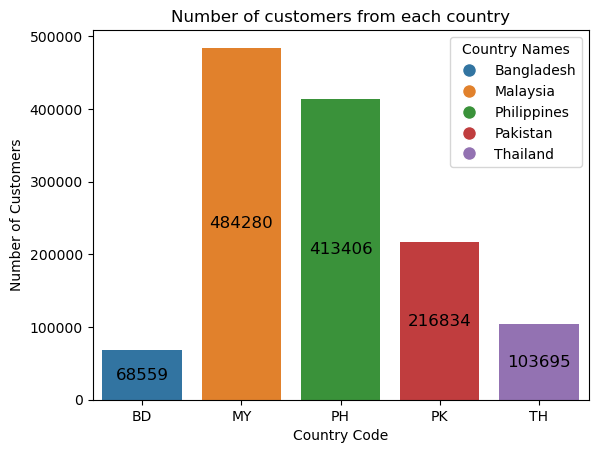

In [6]:
countryNames = {
    'BD': 'Bangladesh',
    'MY': 'Malaysia',
    'PH': 'Philippines',
    'PK': 'Pakistan',
    'TH': 'Thailand'
}

fig = sns.countplot(data=customer, x='country_code')

for p in fig.patches:
    # Get the height of each bar (the count of customers)
    height = p.get_height()
    # Add a centered text at the top of each bar
    fig.text(p.get_x() + p.get_width() / 2, height / 2,  # Position the text at the center of the bar
             str(int(height)),  # The count value
             ha='center',  # Horizontal alignment
             va='center',  # Vertical alignment
             fontsize=12)

# Create a custom legend for the country codes with its respective full name
handles = [plt.Line2D([0], [0], marker='o', color='w', label=countryNames.get(code, code), 
                      markersize=10, markerfacecolor=fig.patches[i].get_facecolor()) 
           for i, code in enumerate(customer['country_code'].unique())]

plt.legend(handles=handles, title="Country Names", loc="upper right")
plt.title('Number of customers from each country')
plt.xlabel('Country Code')
plt.ylabel('Number of Customers')

plt.show()


From the bar graph shown above, we can see that majority of the customers are from Malaysia, while the least number of customers are from Bangladesh

### ii. Distribution of Customer Data

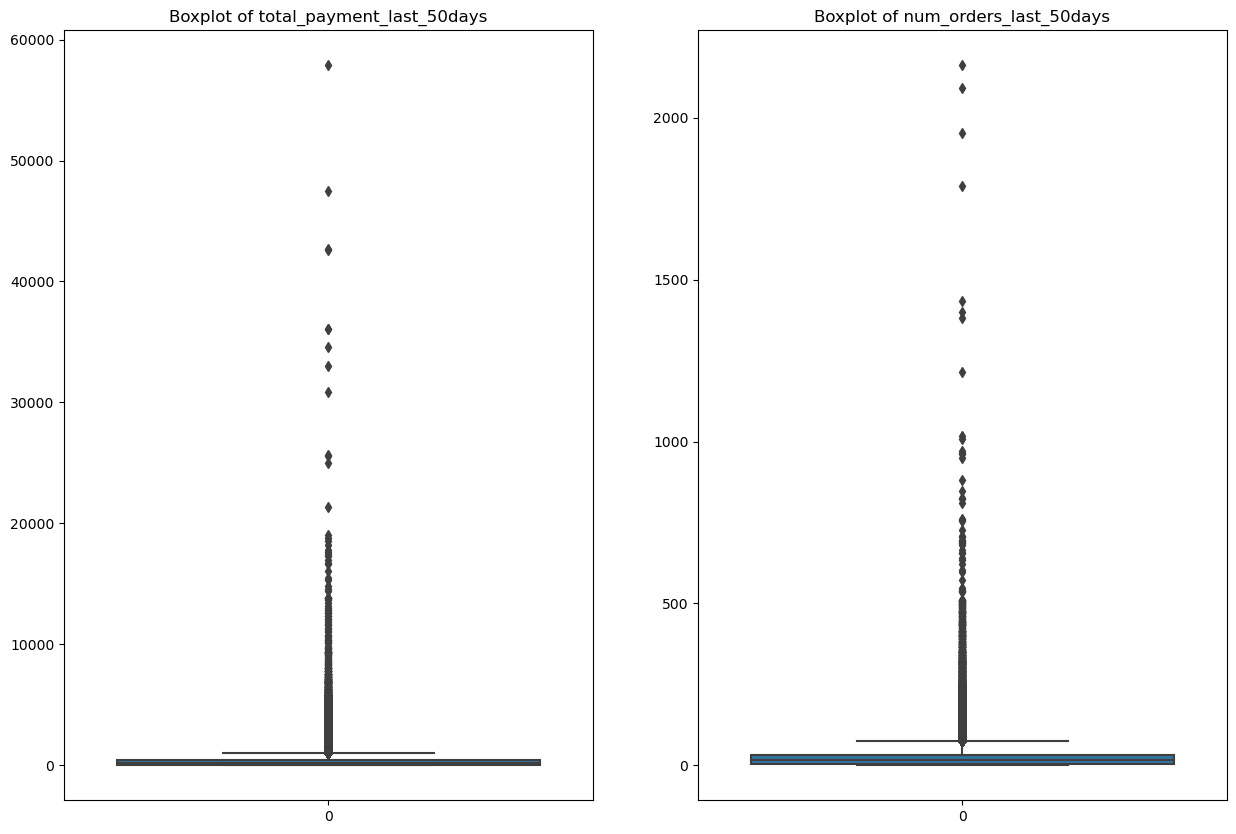

In [7]:
fig, axs = plt.subplots(1,2,figsize=(15,10))

sns.boxplot(data=customer[customer.columns[-3]], ax=axs[0])
axs[0].set_title(f'Boxplot of {customer.columns[-3]}')

sns.boxplot(data=customer[customer.columns[3]], ax=axs[1])
axs[1].set_title(f'Boxplot of {customer.columns[3]}')

plt.show()

From the boxplot shown above, we can see that there are many outliers in `total_payment_last_50days` and `num_orders_last_50days`, with the highest of each being close to 60000 and above 2000 respectively

We can then plot a boxplot without the outliers to get a better view of the distribution of the data

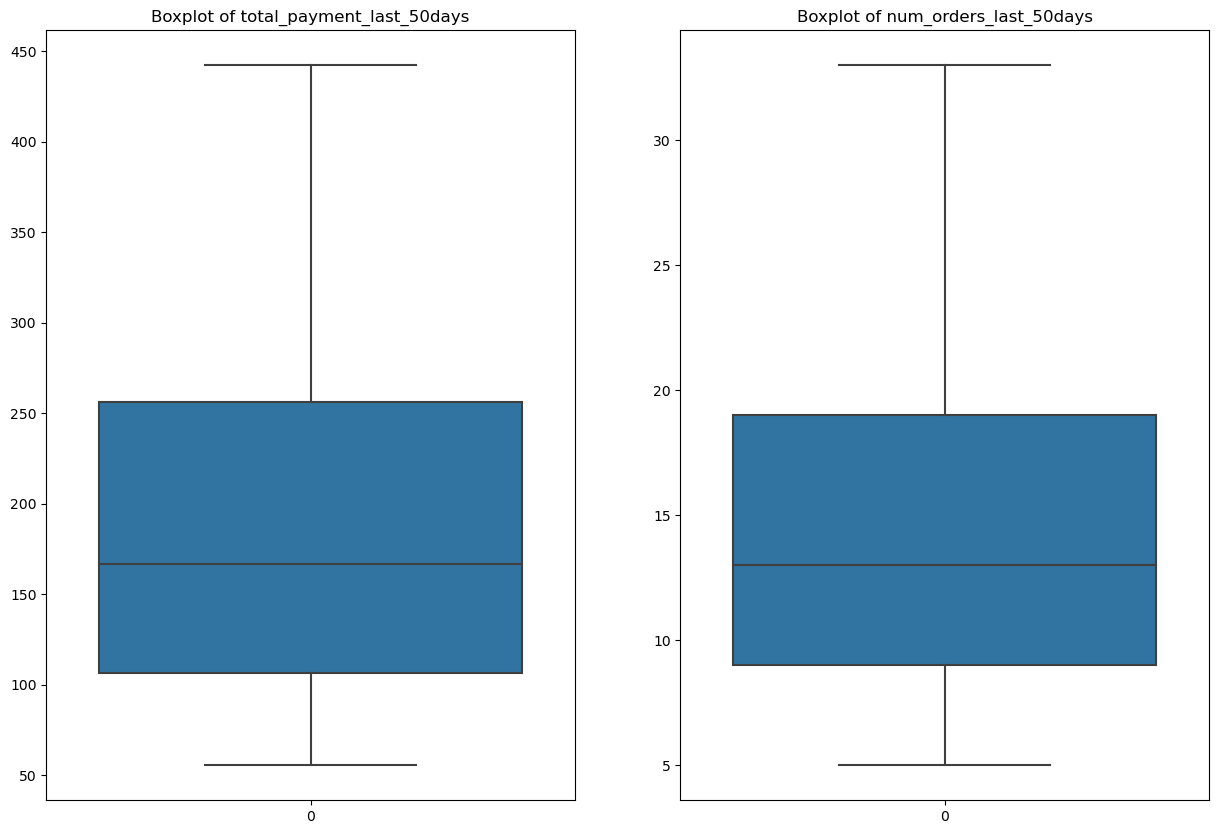

In [8]:
nonOutlierMask = pd.Series([True] * len(customer))

for column in customer.columns[3:-1]:
    upperq = customer[column].quantile(0.75)
    lowerq = customer[column].quantile(0.25)
    
    columnOutliers = (customer[column] > upperq) | (customer[column] < lowerq)
    
    nonOutlierMask &= ~columnOutliers

customerNoOutliers = customer[nonOutlierMask]

fig, axs = plt.subplots(1,2,figsize=(15,10))

sns.boxplot(data=customerNoOutliers[customerNoOutliers.columns[-3]], ax=axs[0])
axs[0].set_title(f'Boxplot of {customerNoOutliers.columns[-3]}')

sns.boxplot(data=customerNoOutliers[customerNoOutliers.columns[3]], ax=axs[1])
axs[1].set_title(f'Boxplot of {customerNoOutliers.columns[3]}')

plt.show()

From the boxplot shown above, we can see that the distribution of `total_payment_last_50days` and `num_orders_last_50days` is slightly skewed towards the right

We can also see that the median for `total_payment_last_50days` is around 170 and the median for `num_orders_last_50days` is around 13. This suggests that customers on average spent about $170 and made about 13 orders in the last 50 days

### iii. Pair Plot of Customer Dataset

c:\Users\scrab\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


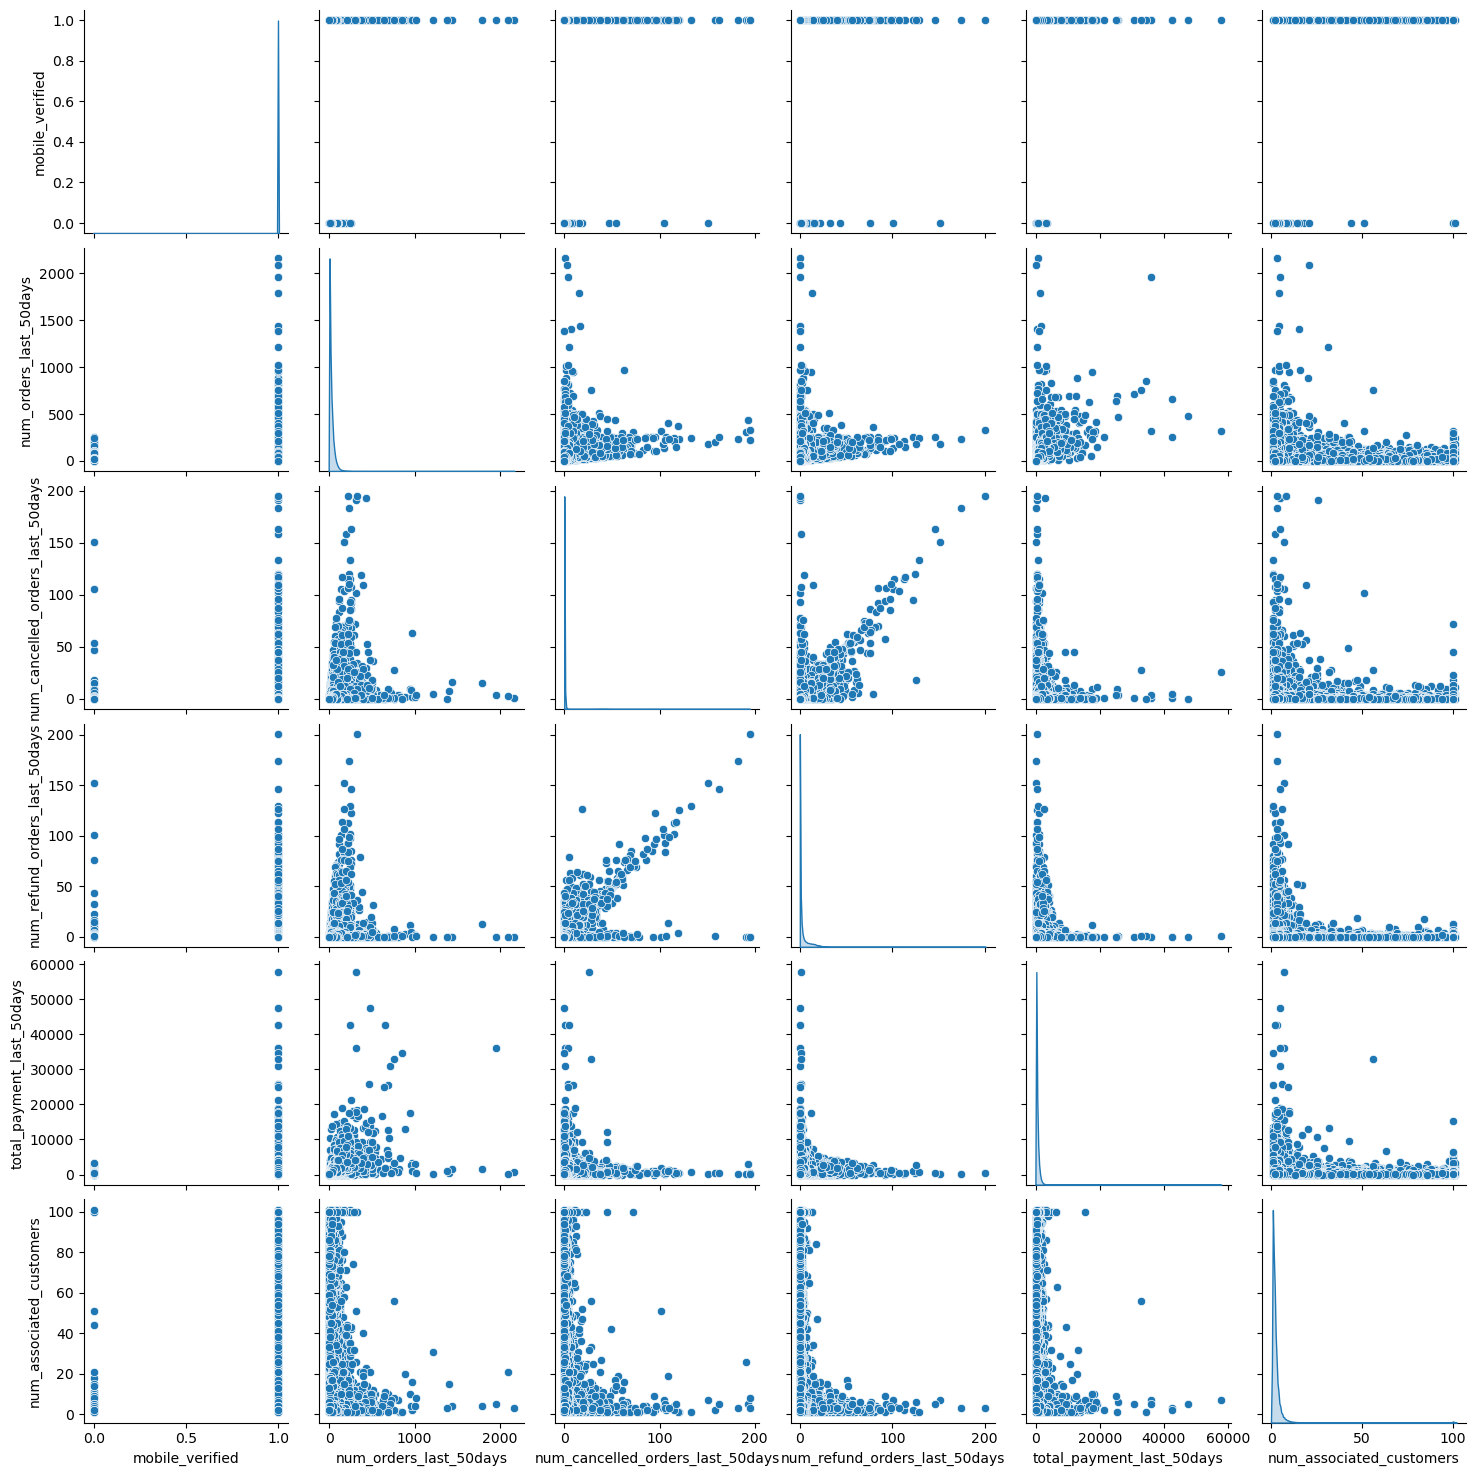

In [9]:
sns.pairplot(data=customer, vars=customer.columns[2:-1], diag_kind='kde')
plt.show()

From the pairplot shown above, we can see that the `num_cancelled_orders_last_50days` is positively correlated with the `num_refund_orders_last_50days`

## Order Dataset

### i. Distribution of Order Data

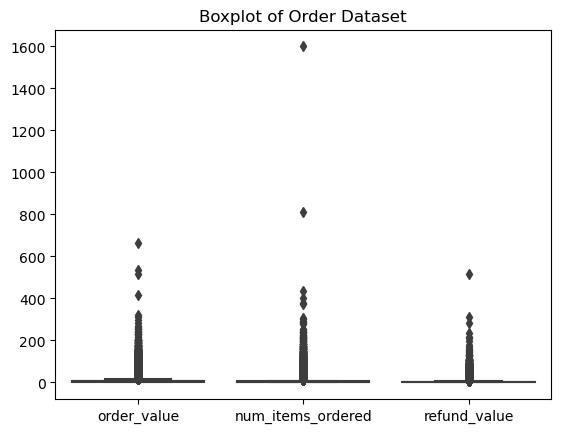

In [10]:
sns.boxplot(data=order.iloc[:, -4:-1])
plt.title('Boxplot of Order Dataset')
plt.show()

We can see that there are many outliers in `order_value`, `num_items_ordered` and `refund_value`, with the highest of each being about 700, 1600 and 500 respectively

We can then plot a boxplot without the outliers to get a better view of the distribution of the data

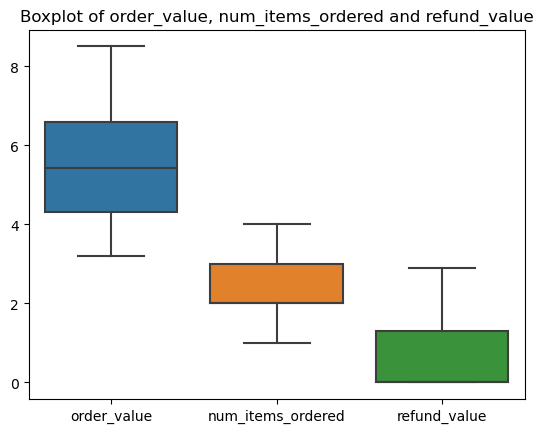

Median of num_items_ordered: 2.0
Median of refund_value: 0.0


In [11]:
nonOutlierMask = pd.Series([True] * len(order))

for column in order.columns[-4:-1]:
    upperq = order[column].quantile(0.75)
    lowerq = order[column].quantile(0.25)
    
    columnOutliers = (order[column] > upperq) | (order[column] < lowerq)
    
    nonOutlierMask &= ~columnOutliers

orderNoOutliers = order[nonOutlierMask]

sns.boxplot(data=orderNoOutliers)
plt.title('Boxplot of order_value, num_items_ordered and refund_value')
plt.show()

print(f'Median of num_items_ordered: {orderNoOutliers.iloc[:,-3].median()}')
print(f'Median of refund_value: {orderNoOutliers.iloc[:,-2].median()}')

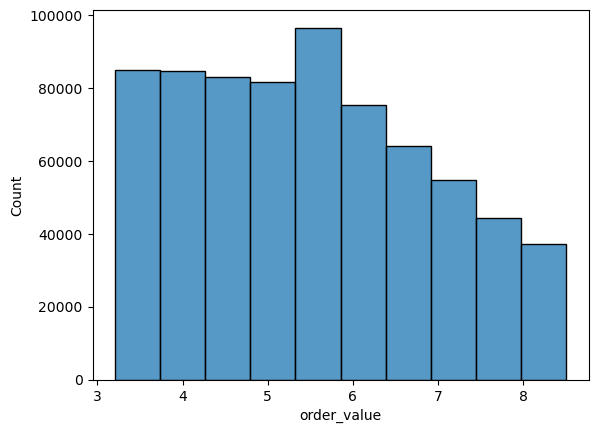

In [23]:
sns.histplot(data=orderNoOutliers['order_value'], bins=10)
plt.show()

From the boxplot shown above, we can see that on average, the `order_value`, `num_items_ordered` and `refund_value` are around 5, 2 and 0 respectively. Special note that the median of `num_items_ordered` and `refund_value` is the same as the 25th percentile, which suggests that the data is skewed towards the right. Same goes for `order_value` where its distribution from the histogram seems to be right-skewed, suggesting that on average there is a lower `num_items_ordered`, `refund_value` and `order_value`

### ii. Pair Plot of Order Data

c:\Users\scrab\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


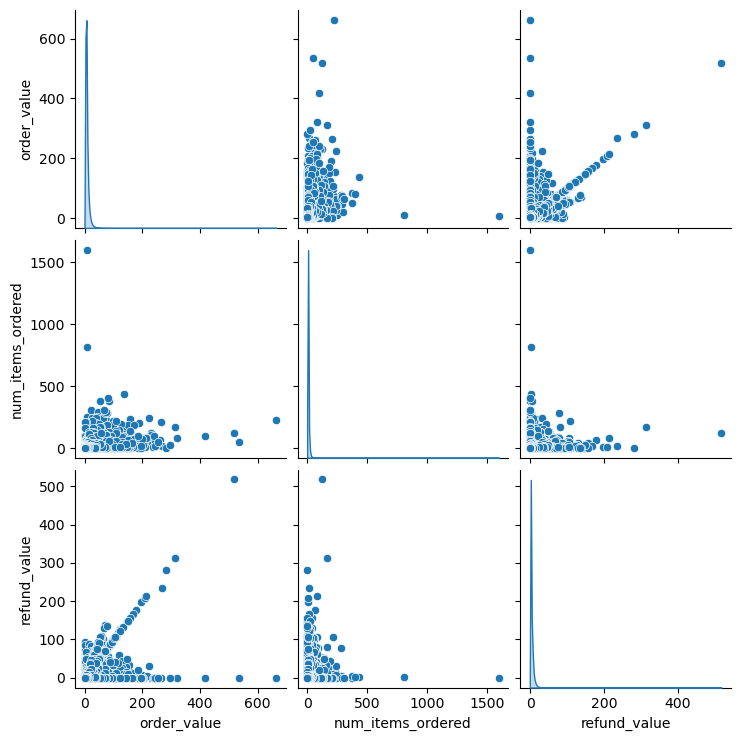

In [13]:
sns.pairplot(data=order, vars=order.columns[-4:-1], diag_kind='kde')
plt.show()

From the pair plot shown above, we can see that `refund_value` and `order_value` are positively correlated to each other